In [1]:
from PEPit import PEP
from PEPit.operators import MonotoneOperator
from PEPit.primitive_steps import proximal_step
import numpy as np
from PEPit.function import Function
import matplotlib.pyplot as plt
import copy
import math
import time
import scipy
from pathlib import Path
import scipy.io
import seaborn as sns
import cvxpy as cp

# !pip install mosek

import cvxopt

%matplotlib inline

In [2]:

def GDA(mu,L,eta,verbose = 1, alt = True, anchored = False):
    # notations
    n_iter = 2
    n_points = n_iter + 1 ## Correspond to 1 iteration with two iterates

    dimG = 2*n_points **2
    # nbPtsA = 2*n_iter + 1 # 


    xs  = np.zeros((2, 1, dimG)) # this is x_* and y_*
    xk  = np.zeros((2, n_iter, dimG))
    gxk = np.zeros((2, n_points, n_points, dimG))
    Lk = np.zeros((2,n_points, n_points, n_points**2-1))

    k=0
    for p in range(2):
        for i in range(n_points):
            for j in range(n_points):
                if i == j ==0:
                    xk[p,i,k] = 1
                elif p == 0:
                    gxk[p,i,j,k] = 1
                    Lk[p,i,j,k-1] = 1
                    Lk[1-p,j,i,k-1] = -1
                else:
                    gxk[p,i,j,k] = -1
                k += 1
    assert(k==2*n_points**2)  


    x_anchor = xk[0,0,:].copy()
    y_anchor = xk[1,0,:].copy()

    for i in range(n_iter-1):
        if alt:

            if anchored == True:
                print("rinima")
                gamma = 1/(i+100)
                xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:] - gamma*(xk[0,i,:] - x_anchor)
                xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+2,i+1,:] - gamma*(xk[1,i,:] - y_anchor)
#             xk[i+1,:] = xk[i,:] - eta * gxk[i+2,i+2,:]

            elif anchored == False:
                xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+1,i+1,:]
    #             yk[i+1,:] = yk[i,:] + eta * gyk[i+2,i+2,:]
                xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+2,i+1,:]
        else:
#             xk[i+1,:] = xk[i,:] - eta * gxk[i+1,i+1,:]
            xk[0,i+1,:] = xk[0,i,:] - eta * gxk[0,i+2,i+2,:]
#             yk[i+1,:] = yk[i,:] + eta * gyk[i+1,i+1,:]
            xk[1,i+1,:] = xk[1,i,:] - eta * gxk[1,i+2,i+2,:]
#     print(xk[1,:])


    # regroup all points to be interpolated in larger matrices
    XX_A = np.concatenate((xs,xk), axis=1)
    GX_A = gxk
    LL_A = Lk
    
    ## SDP part
    nbPtsA = n_points**2
    lambda_conv = {}
    lambda_smooth = {}
    lambda_lip_xy = {}
    for p in range(2):
        for j in range(n_points):
            lambda_conv[p,j] = cp.Variable((n_points, n_points), symmetric=False)
            for i in range(n_points):
                lambda_smooth[i,j,p] = cp.Variable((n_points, n_points), symmetric=False)

    lambda_L = cp.Variable((n_points, n_points))

    lambda_d0 = cp.Variable((1,1), symmetric=False)




    d_k_x = XX_A[0,2,:] 
    d_k_y = XX_A[1,2,:] 
#     C = np.outer(d_k_y,d_k_y)
    C = np.outer(d_k_x,d_k_x) + np.outer(d_k_y,d_k_y)

    cons_SDP = -C
    cons = []
    cons_L = 0
    l_zeros = []
#     l_zeros = [(0,0,0,0),(0,0,0,1),(0,0,1,0),(0,0,1,1),(0,0,1,2),(0,0,0,2),(0,0,2,1),(0,0,2,2)]
#     l_zeros += [(0,1,0,0),(0,1,0,1),(0,1,0,2),(0,1,1,0),(0,1,1,1),(0,1,1,2),(0,1,2,0),(0,1,2,1),(0,1,2,2)]
#     l_zeros += [(0,2,0,0),(0,2,0,2),(0,2,1,0),(0,2,1,1),(0,2,2,0),(0,2,2,1),(0,2,2,2)]
#     l_zeros += [(1,0,0,0),(1,0,0,1),(1,0,0,2),(1,1,1,0),(1,0,1,1),(1,0,2,1),(1,0,2,2)]
#     l_zeros += [(1,1,0,0),(1,1,0,1),(1,1,0,2),(1,1,1,0),(1,1,1,1),(1,1,1,2),(1,1,0,2),(1,1,2,1),(1,1,2,2)]
#     l_zeros += [(1,2,0,0),(1,2,1,0),(1,2,1,1),(1,2,1,2),(1,2,2,0),(1,2,2,1),(1,2,2,2)]
    # Lip + strong conv between (x_i,y_i) and (x_j,y_i)
    for p in range(2):
        for i_x in range(n_points):
            for j_x in range(n_points): 
                for i_y in range(n_points):
                    if i_x != j_x:
                        xi = XX_A[p,i_x,:]
                        xj = XX_A[p,j_x,:]
                        gxj = GX_A[p,j_x, i_y, :]
                        Li = LL_A[p,i_x,i_y,:]
                        Lj = LL_A[p,j_x,i_y,:]
                        A = np.outer(gxj,xi - xj) + mu/2 * np.outer(xi-xj,xi-xj) 
                        cons_SDP = cons_SDP + lambda_conv[p,i_y][i_x,j_x]*  A
                        cons_L = cons_L + lambda_conv[p,i_y][i_x,j_x]*(Li - Lj)
                    else:
                        cons += [lambda_conv[p,i_y][i_x,j_x]==0]

    for i_x in range(n_points):
        for j_x in range(n_points): 
            for i_y in range(n_points):
                for j_y in range(n_points):
                        if (i_x,i_y) != (j_x,j_y):
                            xi = XX_A[0,i_x,:]
                            xj = XX_A[0,j_x,:]
                            yi = XX_A[1,i_y,:]
                            yj = XX_A[1,j_y,:]
                            gxj = GX_A[0,j_x, j_y, :]
                            gyj = -GX_A[1,j_y, j_x, :]
                            Li = LL_A[0,i_x,i_y,:]
                            Lj = LL_A[0,j_x,j_y,:]
                            A = -np.outer(gxj,xi - xj) - np.outer(gyj,yi - yj) - L/2 * np.outer(xi-xj,xi-xj)
                            A -= L/2 * np.outer(yi-yj,yi-yj) 
                            cons_SDP = cons_SDP + lambda_smooth[i_x,i_y,0][j_x,j_y]*  A
                            cons_L = cons_L - lambda_smooth[i_x,i_y,0][j_x,j_y]*(Li - Lj)
                            A = np.outer(gxj,xi - xj) + np.outer(gyj,yi - yj) - L/2 * np.outer(xi-xj,xi-xj)
                            A -= L/2 * np.outer(yi-yj,yi-yj) 
                            cons_SDP = cons_SDP + lambda_smooth[i_x,i_y,1][j_x,j_y]*  A
                            cons_L = cons_L + lambda_smooth[i_x,i_y,1][j_x,j_y]*(Li - Lj)
                        else:
                            cons += [lambda_smooth[i_x,i_y,0][j_x,j_y]==0]
                            cons += [lambda_smooth[i_x,i_y,1][j_x,j_y]==0]

                    

                
    # Constraint for x_0 
    d_0_x = XX_A[0,1,:] 
    d_0_y = XX_A[1,1,:] 
    A = np.outer(d_0_x,d_0_x) + np.outer(d_0_y,d_0_y)
    cons_SDP += lambda_d0[0,0] * A 
    
    #add constraints
    for p in range(2):
        for j in range(n_points):
            cons += [lambda_conv[p,j] >= 0]
    for i in range(n_points):
        for j in range(n_points):
            for p in range(2):
                cons += [lambda_smooth[i,j,p] >= 0]
    cons += [lambda_d0[0,0] >= 0] 

    cons += [cons_SDP  >> 0]
    for i in range(nbPtsA-1):
            cons += [cons_L[i] == 0]

    obj = lambda_d0[0,0] 
    
    prob = cp.Problem(cp.Minimize(obj),cons)

    prob.solve(solver='MOSEK', verbose=verbose)
#     for lam in lambda_smooth_y.values():
#         print(lam.value)
    
    return prob.value, (lambda_conv, lambda_smooth)


In [3]:
# Parameters (analysis):
L_x = L_y = L_xy = L_yx = L = 8.0 # Lipschitz 
mu = 1 # strong monotonicity
n_points = 10
alt_values = []
sim_values = []
anc_alt_values = []
eta_values = np.linspace(0,mu/L**2,n_points)

for eta in eta_values:
    solver_value = GDA(mu,L,eta,verbose = 0, alt = True, anchored=False)[0]
    alt_values.append(solver_value)
    # print(eta)
    # print(solver_value)
    solver_value = GDA(mu,L,eta,verbose = 0, alt = False)[0]
    sim_values.append(solver_value)


    solver_value = GDA(mu,L,eta,verbose = 0, alt = True, anchored= True)[0]
    anc_alt_values.append(solver_value)
    # print(solver_value)

    


rinima
rinima
rinima
rinima
rinima
rinima
rinima
rinima
rinima
rinima


In [4]:
anc_alt_values

[1.000000000023333,
 1.0027412905956312,
 1.0057646385467123,
 1.009079205216791,
 1.0126956517857875,
 1.0166240524768735,
 1.0208802613510093,
 1.025492081249879,
 1.0304736436414514,
 1.0358476294761894]

In [5]:
alt_values

[1.000000000023333,
 1.0027412905956312,
 1.0057646385467123,
 1.009079205216791,
 1.0126956517857875,
 1.0166240524768735,
 1.0208802613510093,
 1.025492081249879,
 1.0304736436414514,
 1.0358476294761894]

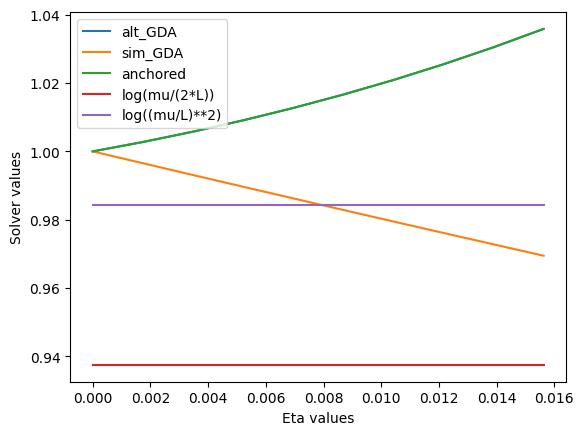

In [6]:
import matplotlib.pyplot as plt
plt.plot(eta_values, np.array(alt_values), label="alt_GDA")
plt.plot(eta_values, np.array(sim_values), label="sim_GDA")
plt.plot(eta_values, np.array(anc_alt_values), label="anchored")
plt.plot(eta_values, [1-mu/(2*L)]*n_points, label ="log(mu/(2*L))")
plt.plot(eta_values, [1-mu**2/L**2]*n_points, label ="log((mu/L)**2)")
plt.xlabel('Eta values')
plt.ylabel('Solver values')
# Set the y-axis limits to be between 0 and 1
# plt.ylim(1e-2, 1)
# plt.xlim(0,1/L)
# 1-kappa = \|x_{t+1} -x^*\|^2/\|x_{t} -x^*\|^2
plt.legend()
plt.show()

In [7]:
mu = 1
L = 4
solver_value,(lambda_conv, lambda_smooth) = GDA(mu,L,1/(4*L),verbose = 0, alt = True)
print(solver_value)

1.0247678018565576


In [8]:
for p in range(2):
    for i in range(3):
        print(f"p: {p}, i: {i}, conv: \n{np.round(lambda_conv[p,i].value,4)}")
        

for p in range(2):
    for i in range(3):
        for j in range(3):
            print(f"p: {p}, i: {i}, j: {j} smooth: \n{np.round(lambda_smooth[i,j,p].value,4)}")
        
print(lambda_conv[0,0][2,0].value)
print(mu/L**2/5)

p: 0, i: 0, conv: 
[[-0.      0.      0.    ]
 [ 0.0248 -0.      0.    ]
 [ 0.0929  0.     -0.    ]]
p: 0, i: 1, conv: 
[[-0.      0.1197  0.    ]
 [ 0.0547 -0.      0.    ]
 [ 0.      0.     -0.    ]]
p: 0, i: 2, conv: 
[[-0.      0.0382  0.    ]
 [ 0.     -0.      0.    ]
 [ 0.      0.     -0.    ]]
p: 1, i: 0, conv: 
[[-0.      0.      0.    ]
 [ 0.0268 -0.      0.    ]
 [ 0.0929  0.     -0.    ]]
p: 1, i: 1, conv: 
[[-0.      0.      0.1176]
 [ 0.0391 -0.      0.    ]
 [ 0.013   0.     -0.    ]]
p: 1, i: 2, conv: 
[[-0.      0.0228  0.018 ]
 [ 0.     -0.      0.    ]
 [ 0.      0.     -0.    ]]
p: 0, i: 0, j: 0 smooth: 
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0. -0.  0.]]
p: 0, i: 0, j: 1 smooth: 
[[ 0.     -0.      0.    ]
 [ 0.      0.      0.0382]
 [ 0.      0.      0.    ]]
p: 0, i: 0, j: 2 smooth: 
[[ 0.  0. -0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
p: 0, i: 1, j: 0 smooth: 
[[ 0.  0.  0.]
 [-0.  0.  0.]
 [ 0.  0.  0.]]
p: 0, i: 1, j: 1 smooth: 
[[ 0.      0.      0.    ]
 [ 0.     -0.    

In [9]:
l_zeros = [(0,0,0,0),(0,0,0,1),(0,0,1,0),(0,0,1,1),(0,0,1,2),(0,0,0,2),(0,0,2,1),(0,0,2,2)]
l_zeros += [(0,1,0,0),(0,1,0,1),(0,1,0,2),(0,1,1,0),(0,1,1,1),(0,1,1,2),(0,1,2,0),(0,1,2,1),(0,1,2,2)]
l_zeros += [(0,2,0,0),(0,2,0,2),(0,2,1,0),(0,2,1,1),(0,2,2,0),(0,2,2,1),(0,2,2,2)]
l_zeros += [(1,0,0,0),(1,0,0,1),(1,0,0,2),(1,1,1,0),(1,0,1,1),(1,0,2,1),(1,0,2,2)]
l_zeros += [(1,1,0,0),(1,1,0,1),(1,1,0,2),(1,1,1,0),(1,1,1,1),(1,1,1,2),(1,1,0,2),(1,1,2,1),(1,1,2,2)]
l_zeros += [(1,2,0,0),(1,2,1,0),(1,2,1,1),(1,2,1,2),(1,2,2,0),(1,2,2,1),(1,2,2,2)]



In [10]:
def GD(mu,L,eta,verbose = 1, alt = True):
    # notations
    n_iter = 2
    n_points = n_iter + 1 ## Correspond to 1 iteration with two iterates

    dimG = n_points 
    # nbPtsA = 2*n_iter + 1 # 


    xs  = np.zeros((1, dimG)) # this is x_*
    Lxs = np.zeros((1, dimG))
    xk  = np.zeros((n_iter, dimG))
    xk[0,0] = 1
    gxk = np.zeros((n_points, dimG))
    Lk = np.zeros((n_points, dimG-1))

    k=0
    for i in range(n_points):
            if i == 0:
                k+=1
            else: 
                gxk[i,k] = 1
                Lk[i,k-1] =1
                k += 1
    assert(k==n_points)           



    d_0 = 1 
    for i in range(n_iter-1):
        if alt:
            xk[i+1,:] = xk[i,:] - eta * gxk[i+2,:]
        else:
            xk[i+1,:] = xk[i,:] - eta * gxk[i+1,:]




    # regroup all points to be interpolated in larger matrices
    XX_A = np.concatenate((xs,xk), axis=0)
    GX_A = gxk
    LL_A = Lk
    
    ## SDP part
    nbPtsA = n_points**2

    lambda_smooth_x = cp.Variable((n_points, n_points))
    lambda_d0 = cp.Variable((1,1), symmetric=False)




    d_k_x = XX_A[2,:] 
#     C = np.outer(d_k_y,d_k_y)
    C = np.outer(d_k_x,d_k_x) 
#     + np.outer(d_k_y,d_k_y)

    cons_SDP = -C
    cons = []
    cons_L = 0

    # Lip + strong conv between (x_i,y_i) and (x_j,y_i)
    for i in range(n_points):
        for j in range(n_points):
            if i != j:
                xi = XX_A[i,:]
                xj = XX_A[j,:]
                gxi = GX_A[i,:]
                gxj = GX_A[j,:]
                Li = LL_A[i,:]
                Lj = LL_A[j,:]
                # strong convexity between (x_i,y_i), and (x_j,y_i)
                # L(x_i,y_i) \geq L(x_j,y_i) + <nabla_x L(x_j,y_i),x_i-x_j> + \mu/2 \|x_i-x_j\|**2
                A = mu/(2*(1-mu/L_x)) * np.outer(xi-xj-(gxi-gxj)/L_x,xi-xj-(gxi-gxj)/L_x) 
                A += np.outer(gxi-gxj,gxi-gxj)/(2*L_x) + np.outer(gxj,xi - xj)
                cons_SDP = cons_SDP + lambda_smooth_x[i,j]*A
                cons_L = cons_L + lambda_smooth_x[i,j]*(Li - Lj)
            else:
                cons += [lambda_smooth_x[i,j]==0]
                
    # Constraint for x_0 
    d_0_x = XX_A[1,:] 
    A = np.outer(d_0_x,d_0_x)
    cons_SDP += lambda_d0[0,0] * A 
    
    #add constraints
    cons += [lambda_smooth_x >= 0]
    cons += [lambda_d0[0,0] >= 0] 

    cons += [cons_SDP  >> 0]
    for i in range(n_points-1):
            cons += [cons_L[i] == 0]

    obj = lambda_d0[0,0] 
    
    prob = cp.Problem(cp.Minimize(obj),cons)

    prob.solve(solver='MOSEK', verbose=verbose)
    
    return prob.value



In [11]:
# Parameters (analysis):
L_x = L_y = L_xy = L_yx = L = 4.0 # Lipschitz 
mu = .1 # strong monotonicity
n_points = 20
alt_values = []
sim_values = []
eta_values = np.linspace(0,2/L,n_points)

for eta in eta_values:
    solver_value_1 = GD(mu,L,eta,verbose = 0, alt = True)
    alt_values.append(solver_value_1)
    solver_value_2 = GD(mu,L,eta,verbose = 0, alt = False)
    sim_values.append(solver_value_2)
    print(f"eta {eta}, true {solver_value_1}, false {solver_value_2}")

eta 0.0, true 1.0000000000002423, false 1.0000000000002423
eta 0.02631578947368421, true 0.9947575451300842, false 0.9947437625404593
eta 0.05263157894736842, true 0.9895562073418244, false 0.9895013573410507
eta 0.07894736842105263, true 0.9843955554005653, false 0.9842728337604151
eta 0.10526315789473684, true 0.9792751721851034, false 0.9790581664679557
eta 0.13157894736842105, true 0.9741946360167169, false 0.9738573288403459
eta 0.15789473684210525, true 0.9691535355228116, false 0.9686703577191466
eta 0.18421052631578946, true 0.9641514667181642, false 0.9634972288832181
eta 0.21052631578947367, true 0.9591880131795076, false 0.9583379490842782
eta 0.23684210526315788, true 0.9542627925544221, false 0.9531925198601772
eta 0.2631578947368421, true 0.9493754114080608, false 0.9480609411557839
eta 0.2894736842105263, true 0.9445254811642487, false 0.9429431848158237
eta 0.3157894736842105, true 0.9397126202653181, false 0.9378393163015895
eta 0.3421052631578947, true 0.9349364520315

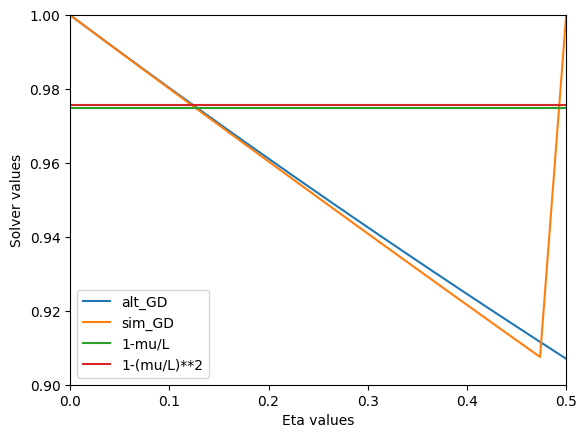

In [12]:
import matplotlib.pyplot as plt
plt.plot(eta_values, alt_values, label="alt_GD")
plt.plot(eta_values, sim_values, label="sim_GD")
plt.plot(eta_values, [1-mu/L]*n_points, label ="1-mu/L")
plt.plot(eta_values, [L/(L+mu)]*n_points, label ="1-(mu/L)**2")
plt.xlabel('Eta values')
plt.ylabel('Solver values')
# Set the y-axis limits to be between 0 and 1
plt.ylim(.9, 1)
plt.xlim(0,2/L)
plt.legend()
plt.show()

In [13]:
print(np.round(lambda_lip.value,5)*2*L**2)

NameError: name 'lambda_lip' is not defined

In [ ]:
print(np.round(lambda_str.value,3)*L**2/mu)

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]]


In [ ]:
keyprob

Problem(Minimize(Expression(AFFINE, UNKNOWN, ())), [Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(AFFINE, UNKNOWN, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Expression(A

In [ ]:
[(i,j) for i in range(3) for j in range(3) ] 

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [ ]:
print(lambda_d0.value)

[[0.998125]]
